In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tqdm

%matplotlib inline

In [23]:
import warnings

warnings.filterwarnings('ignore')

Downloading datasets

In [24]:
from sklearn.datasets import fetch_covtype
dataset = fetch_covtype()

Creating a dataframe

In [25]:
# Selecting needed elements
X = dataset['data']
y = dataset['target']
features = dataset['feature_names']

# pandas dataframe
df = pd.DataFrame(X, columns=features)
df['Target'] = y

print(f'The dataframe shape is {df.shape}')

The dataframe shape is (581012, 55)


In [26]:
from matplotlib import cm

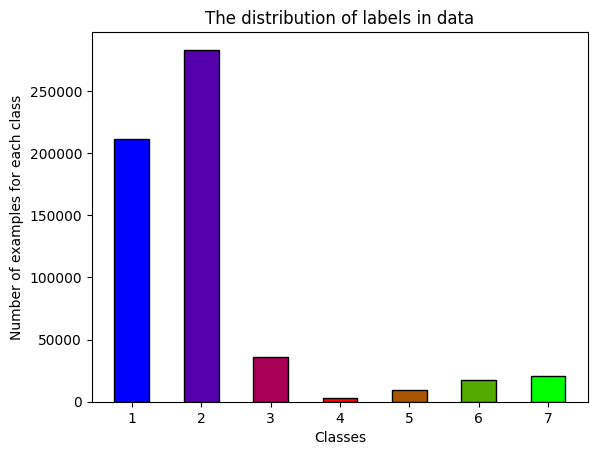

In [27]:
hist, bins = np.histogram(y,bins=7)
cmap = cm.get_cmap('brg');

bins = np.unique(y) # For the bins to come
plt.bar(bins, hist, width=0.5,edgecolor='black',color=cmap(np.linspace(0, 1, len(hist))));
plt.xticks(range(1,8), range(1,8));
plt.title('The distribution of labels in data')
plt.ylabel('Number of examples for each class')
plt.xlabel('Classes');

Balancing the dataset

In [28]:
from imblearn.under_sampling import RandomUnderSampler

In [29]:
sampler = RandomUnderSampler(random_state=54)

x_resampled, y_resampled = sampler.fit_resample(X, y)

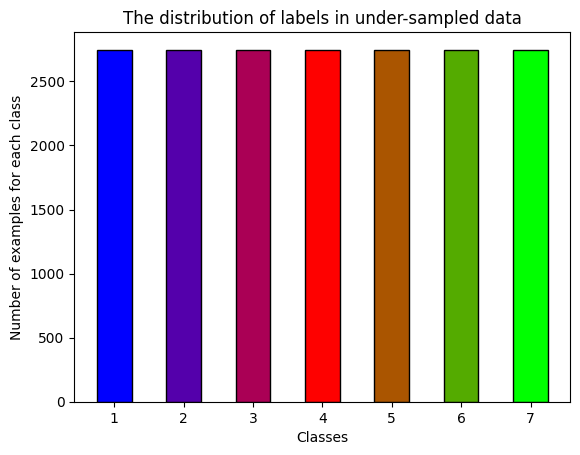

In [30]:
hist, bins = np.histogram(y_resampled,bins=7)
cmap = cm.get_cmap('brg');

bins = np.unique(y_resampled) # For the bins to come
plt.bar(bins, hist, width=0.5,edgecolor='black',color=cmap(np.linspace(0, 1, len(hist))));
plt.xticks(range(1,8), range(1,8));
plt.title('The distribution of labels in under-sampled data')
plt.ylabel('Number of examples for each class')
plt.xlabel('Classes');

## 3-1: Data split & DT model

Data splitting

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
# Split resmapled data
x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(
    x_resampled,
    y_resampled,
    random_state = 54,
    test_size = 0.15,
    shuffle = True
)

# Split main data
x_train, x_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state = 54,
    test_size = 0.15,
    shuffle = True
)

Normalizing

In [33]:
from sklearn.preprocessing import StandardScaler

In [34]:
# scaler
scaler = StandardScaler()
scaler.fit(x_train)

# scaling datasets
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

DT model training

In [35]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold

In [ ]:
dt = DecisionTreeClassifier(random_state=54)
dt1 = clone(dt)
dt3 = clone(dt)
dt2 = clone(dt)

Train all model

In [ ]:
# With under-sampled data
dt.fit(x_train_r, y_train_r)
print(f'Model score for under-sampled data is: {dt.score(x_test_r, y_test_r):0.4f}', end='\n\n')

# With normal data
dt1.fit(x_train, y_train)
print(f'Model score for normal data is: {dt1.score(x_test, y_test):0.4f}', end='\n\n')

# With Weighted classes
weight = [
    len(y)/len(y[y==1]),
    len(y)/len(y[y==2]),
    len(y)/len(y[y==3]),
    len(y)/len(y[y==4]),
    len(y)/len(y[y==5]),
    len(y)/len(y[y==6]),
    len(y)/len(y[y==7])
]
w_train = [weight[a-1] for a in y_train]
w_test = [weight[a-1] for a in y_test]
dt2.fit(x_train, y_train, w_train)
print(f"The weight for each class is : {np.round(weight).astype('int16')}")
print(f'Model score for weighted data is: {dt2.score(x_test,y_test,w_test):0.4f}', end='\n\n')

# With K-fold method
kfold_score = cross_val_score(dt, X, y, cv=5)
print(f'Model score for 5-fold CV is : {np.mean(kfold_score):.4f} --> (mean value)', end='\n\n')

# Stratified K-fold model
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=54)
fold_acc = {'train':[], 'val':[]}
fold_hat = {'train':[], 'val':[]}
fold_ground = {'train':[], 'val':[]}
fold_input = {'train':[], 'val':[]}
all_models = []
# Train model
for train_index, val_index in kf.split(x_train,y_train):

    X_train_fold, X_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    fold_input['train'].append(X_train_fold)
    fold_input['val'].append(X_val_fold)
    fold_ground['train'].append(y_train_fold)
    fold_ground['val'].append(y_val_fold)

    # Train selected folds
    model = clone(dt3)
    model.fit(X_train_fold,y_train_fold)

    # Accuracy
    train_hat = model.predict(X_train_fold)
    fold_hat['train'].append(train_hat)
    train_hat = train_hat == y_train_fold
    train_score = np.sum(train_hat.astype('float64'))/len(y_train_fold)
    fold_acc['train'].append(train_score)

    val_hat = model.predict(X_val_fold)
    fold_hat['val'].append(val_hat)
    val_hat = val_hat == y_val_fold
    val_score = np.sum(val_hat.astype('float64'))/len(y_val_fold)
    fold_acc['val'].append(val_score)

    # Saving all models
    all_models.append(model)
skf_score = np.mean(fold_acc['val'])
print(f'Model score for Stratified 5-fold CV is {skf_score:0.4f} --> (mean value)')

Model score for under-sampled data is: 0.7945

Model score for normal data is: 0.9421

The weight for each class is : [  3   2  16 212  61  33  28]
Model score for weighted data is: 0.8878

Model score for 5-fold CV is : 0.5580 --> (mean value)

Model score for Stratified 5-fold CV is 0.9345 --> (mean value)


Classification report

In [ ]:
models = [dt, dt1, dt2, all_models[np.argmax(fold_acc['val'])]]
test_datas = [x_test_r, x_test, x_test, fold_input['val'][np.argmax(fold_acc['val'])]]
test_y = [y_test_r, y_test, y_test, fold_ground['val'][np.argmax(fold_acc['val'])]]
model_names = ['Under sampled', 'Normal', 'Weighted', 'Stratified 5-fold']


for i, model in enumerate(models):

    print(f'For {model_names[i]} model')
    hat = model.predict(test_datas[i])
    cr = classification_report(test_y[i], hat)
    print(cr)

For Under sampled model
              precision    recall  f1-score   support

           1       0.69      0.64      0.66       402
           2       0.63      0.62      0.63       422
           3       0.78      0.77      0.77       416
           4       0.93      0.92      0.92       404
           5       0.86      0.90      0.88       408
           6       0.75      0.79      0.77       403
           7       0.91      0.93      0.92       430

    accuracy                           0.79      2885
   macro avg       0.79      0.79      0.79      2885
weighted avg       0.79      0.79      0.79      2885

For Normal model
              precision    recall  f1-score   support

           1       0.94      0.94      0.94     31762
           2       0.95      0.95      0.95     42618
           3       0.93      0.94      0.94      5380
           4       0.84      0.85      0.85       413
           5       0.84      0.87      0.85      1477
           6       0.88      0.89    

some characteristics of the tree

In [ ]:
tree_ob = dt1.tree_

# max depth
md = tree_ob.max_depth
print(f'Max depth of the tree is {md}', end='\n\n')

# number of samples in the leaves
ns = tree_ob.n_node_samples[-1]
print(f'There are {ns} number of samples at leaves', end='\n\n')

# Impurity at leaves
i_in_leaf = tree_ob.impurity[-1]
print(f'Impurity at leaves is {i_in_leaf}')

Max depth of the tree is 43

There are 2 number of samples at leaves

Impurity at leaves is 0.0


Visualization of DT

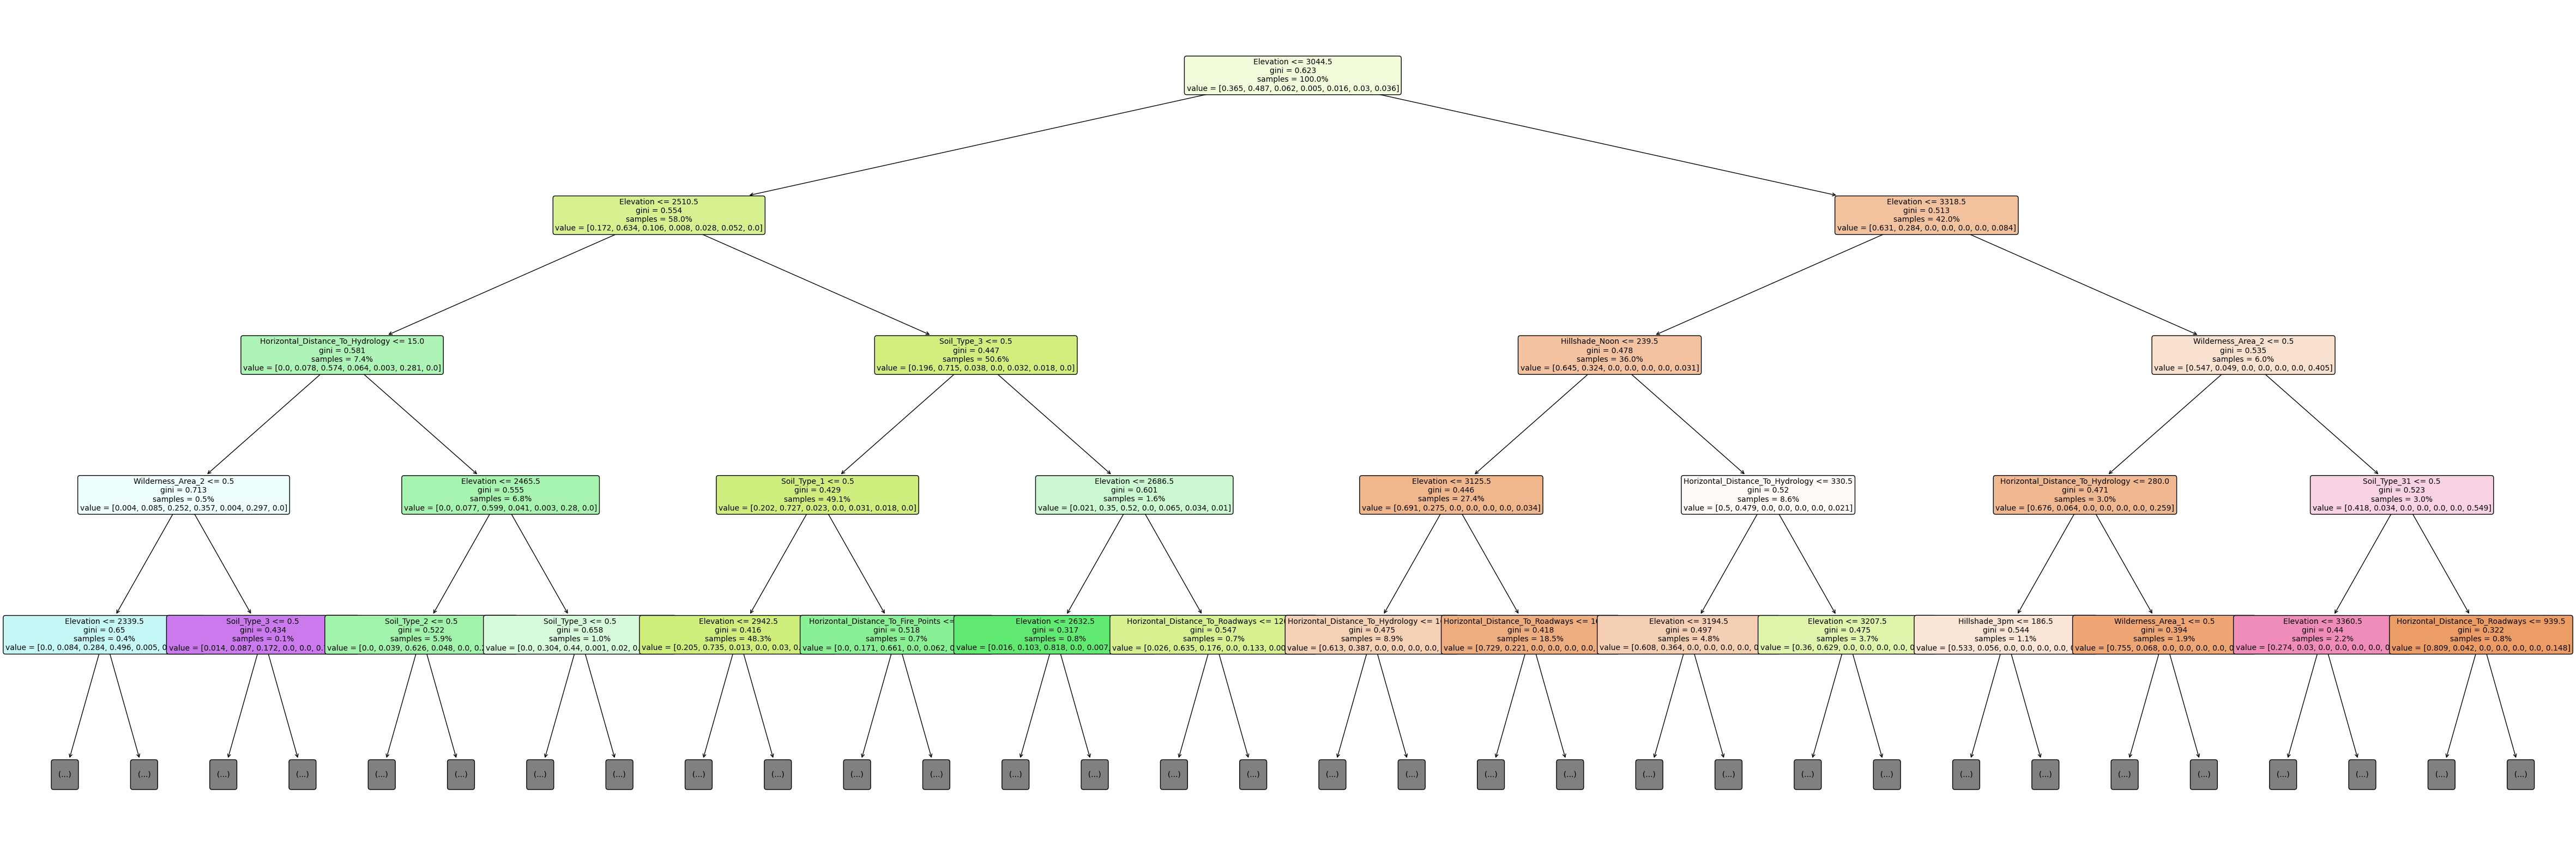

In [ ]:
plt.figure(figsize=(60,20))
plot_tree(dt1, max_depth=4, filled=True , fontsize=10,feature_names=features, rounded=True, proportion=True);
# export_text(dt1,feature_names=features)

## 3-2: Confusiont matrix and metrics & hyperparameters


Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

Text(0.5, 1.0, 'Confusion Matrix for Test dat')

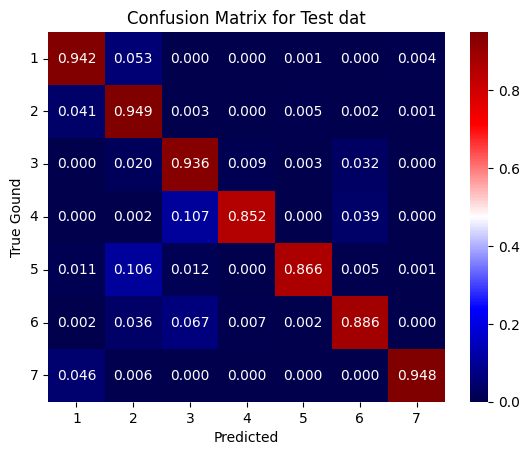

In [ ]:
# Calclating Confucsion matrix
hat = dt1.predict(x_test)
cm_1 = confusion_matrix(y_test, hat)
cm_sum = np.sum(cm_1,axis=1).reshape(-1,1)
cm = cm_1/cm_sum

# Plotting confusion matrix
sns.heatmap(cm, annot=True, cmap='seismic', fmt='.3f');
plt.xticks(np.array(range(0,7)).astype('float32')+0.5, range(1,8));
plt.yticks(np.array(range(0,7)).astype('float32')+0.5, range(1,8), rotation=0);
plt.xlabel('Predicted')
plt.ylabel('True Gound')
plt.title('Confusion Matrix for Test dat')

Metrics

In [ ]:
# Calculate overall accuracy
overall_accuracy = np.trace(cm) / float(np.sum(cm))

# Calculate precision, recall, and F1-score for each class
class_metrics = classification_report(y_test, hat, output_dict=True)

# Loop to calculate and print metrics
m_dic = {'class':[], 'precision':[],  'recall':[],  'f1_score':[]}
for c in np.unique(y_test):

    class_d = class_metrics[str(c)]
    per = class_d['precision']
    f1 = class_d['f1-score']
    rec = class_d["recall"]

    m_dic['class'].append(str(c))
    m_dic['precision'].append(np.round(per,4))
    m_dic['recall'].append(np.round(rec,4))
    m_dic['f1_score'].append(np.round(f1,4))

# Creating a DataFrame for metrics
mdf = pd.DataFrame(m_dic)
mdf.head(7)

,class,precision,recall,f1_score
0,1,0.9407,0.9422,0.9415
1,2,0.9517,0.9492,0.9505
2,3,0.9345,0.9359,0.9352
3,4,0.8441,0.8523,0.8482
4,5,0.8376,0.8659,0.8515
5,6,0.8847,0.8861,0.8854
6,7,0.9487,0.9477,0.9482


hyperparameters

In [ ]:
main_model = DecisionTreeClassifier(max_depth=20, min_samples_split=20, min_samples_leaf=20, max_features=20, random_state=54)

# Max depth
acc_md = []
hyper_md = np.arange(1,40,1)
pbar = tqdm.tqdm(hyper_md)
for i in pbar:
    test_model_md  = clone(main_model)
    test_model_md.max_depth = i
    test_model_md.fit(x_train_scaled, y_train)
    score = test_model_md.score(x_test_scaled, y_test)
    acc_md.append(score)

# Mininum sapmles split
acc_mss = []
hyper_mss = np.arange(1500,50,-10)
pbar = tqdm.tqdm(hyper_mss)
for i in pbar:
    test_model_mss = clone(main_model)
    test_model_mss.min_samples_split = i
    test_model_mss.fit(x_train_scaled, y_train)
    score = test_model_mss.score(x_test_scaled, y_test)
    acc_mss.append(score)

# Minimum samples leaf
acc_msl = []
hyper_msl = np.arange(1000,10,-5)
pbar = tqdm.tqdm(hyper_msl)
for i in pbar:
    test_model_msl = clone(main_model)
    test_model_msl.min_samples_leaf = i
    test_model_msl.fit(x_train_scaled, y_train)
    score = test_model_msl.score(x_test_scaled, y_test)
    acc_msl.append(score)


100%|██████████| 198/198 [09:00<00:00,  2.73s/it]


100%|██████████| 49/49 [04:01<00:00,  4.93s/it]


Text(0.5, 0, 'Max Features')

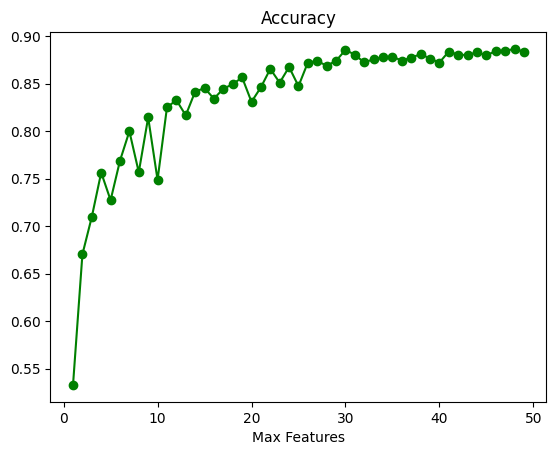

In [ ]:
main_model = DecisionTreeClassifier(max_depth=20, min_samples_split=20, min_samples_leaf=20, max_features=20, random_state=54)
# Maximum features
acc_mf = []
hyper_mf = np.arange(1,50,1)
pbar = tqdm.tqdm(hyper_mf)
for i in pbar:
    test_model_mf = clone(main_model)
    test_model_mf.max_features = i
    test_model_mf.fit(x_train_scaled, y_train)
    score = test_model_mf.score(x_test_scaled, y_test)
    acc_mf.append(score)

# Min features
plt.figure()
plt.plot(hyper_mf, acc_mf, '-og')
plt.title('Accuracy')
plt.xlabel('Max Features')


Plotting

Text(0.5, 0, 'Max Features')

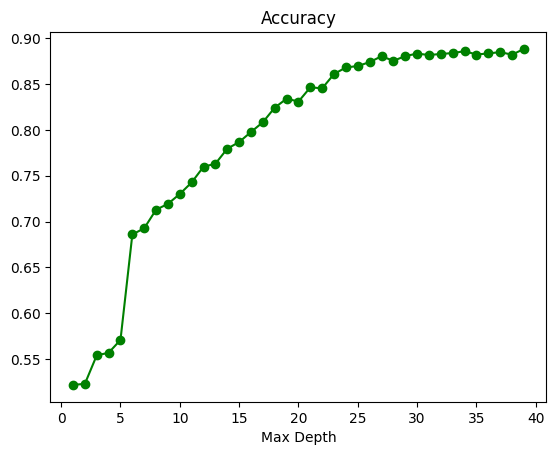

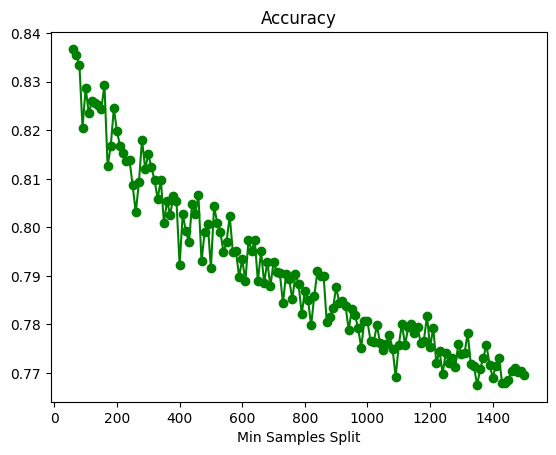

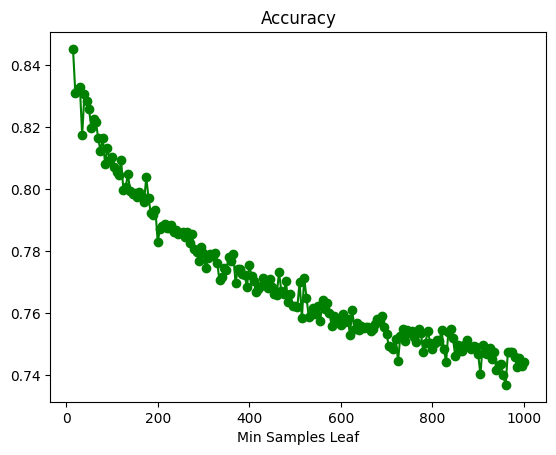

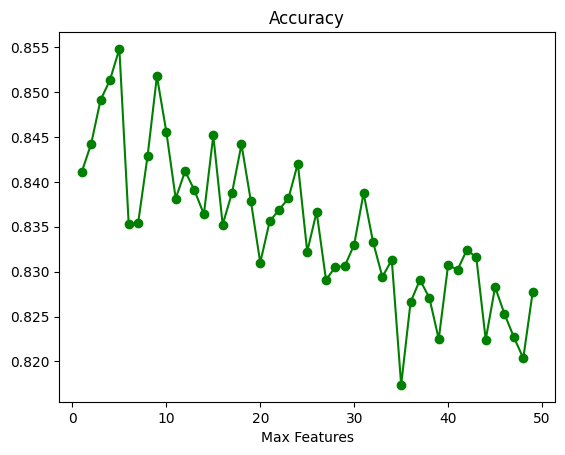

In [ ]:
# max depth
plt.figure()
plt.plot(hyper_md, acc_md, '-og')
plt.title('Accuracy')
plt.xlabel('Max Depth')

# min samples split
plt.figure()
plt.plot(hyper_mss, acc_mss, '-og')
plt.title('Accuracy')
plt.xlabel('Min Samples Split')

# min samples leaf
plt.figure()
plt.plot(hyper_msl, acc_msl, '-og')
plt.title('Accuracy')
plt.xlabel('Min Samples Leaf')

# Min features
plt.figure()
plt.plot(hyper_mf, acc_mf, '-og')
plt.title('Accuracy')
plt.xlabel('Max Features')

In [36]:
from sklearn.model_selection import GridSearchCV

In [37]:
main_model = DecisionTreeClassifier(max_depth=20, min_samples_split=20, min_samples_leaf=20, max_features=20, random_state=54)
grid_model = clone(main_model)

grid_param = {
    'max_depth': np.arange(30,42,3),
    'min_samples_leaf': np.arange(2,50,10),
    'max_features': np.arange(40,50,5)
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(grid_model, grid_param, cv=3, scoring='accuracy', verbose=1)

grid_search.fit(x_train_scaled, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(max_depth=20, max_features=20,
                                              min_samples_leaf=20,
                                              min_samples_split=20,
                                              random_state=54),
             param_grid={'max_depth': array([30, 33, 36, 39]),
                         'max_features': array([40, 45]),
                         'min_samples_leaf': array([ 2, 12, 22, 32, 42])},
             scoring='accuracy', verbose=1)

In [41]:
print(f'The best score on Test data is :{grid_search.score(x_test_scaled,y_test):.4f}')
print(f'The best parameters are :{grid_search.best_params_}')



The best score on Test data is :0.9239
The best parameters are :{'max_depth': 36, 'max_features': 45, 'min_samples_leaf': 2}


## 3-3: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(max_depth=40)
rf.fit(x_train_scaled, y_train)

RandomForestClassifier(max_depth=40)

In [ ]:
test_score = rf.score(x_test_scaled, y_test)
print(f'The score of random forest model on test data is {test_score:.4f}', end='\n\n')

print('Classification report for the random forest model is')
hattt = rf.predict(x_test_scaled)
cr = classification_report(y_test, hattt)
print(cr)

The score of random forest model on test data is 0.9557

Classification report for the random forest model is
              precision    recall  f1-score   support

           1       0.97      0.94      0.95     31762
           2       0.95      0.98      0.96     42618
           3       0.95      0.96      0.95      5380
           4       0.90      0.87      0.89       413
           5       0.93      0.78      0.85      1477
           6       0.93      0.90      0.91      2538
           7       0.97      0.95      0.96      2964

    accuracy                           0.96     87152
   macro avg       0.94      0.91      0.93     87152
weighted avg       0.96      0.96      0.96     87152

